# Lectura de matrices
En este archivo leemos las matrices y realizamos los respectivos calculos sobre ellas y observamos los resultados

In [1]:
import math, subprocess
import pandas as pd
import numpy as np
import random, math
import os
import shutil
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import sys
from IPython.display import display, clear_output
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Metodos auxiliares
%run metodos.ipynb

In [3]:
# Constantes necesarias
path_instancias_karate = F"./instancias"
path_karate = F"{path_instancias_karate}/karateclub_analisis"

In [4]:
# Constantes necesarias
path_instancias_facebook = F"./instancias"
path_egofacebook = F"{path_instancias_facebook}/ego-facebook-analisis"
path_egofacebook_edge = F"{path_egofacebook}/ego-facebook.edges"
path_egofacebook_feat = F"{path_egofacebook}/ego-facebook.feat"

## Metodo de la potencia - Ejecución de C++

In [5]:
def correr_metodo_potencia(archivo, iteraciones, convergencia):
    process = subprocess.Popen(
        ["./metodo_potencia", archivo, str(iteraciones), str(convergencia)], 
        stderr=subprocess.PIPE, 
        stdout=subprocess.PIPE, 
        stdin=subprocess.PIPE, 
        universal_newlines = True)
    exit_code = process.wait()
    if exit_code != 0: 
        print(F"Hubo un error en la experimentacion con la instancia {archivo}")
        
    process.stdin.close();
    process.stdout.close();
    process.stderr.close();

## Lectura de matrices y escritura de matrices y resultados

In [6]:
matriz = obtener_matriz('./instancias/karateclub_analisis/karateclub_matriz.txt', 'f')

## Funciones necesarias para el analisis

#### Matriz Laplaciana
Brinda información sobre la red.
$$Lv = \lambda v$$
Se puede demostrar que para redes no dirigidas, L es simétrica semidefinida positiva.
Por lo tanto, sus autovalroes son mayores o iguales a cero.
Nos interesa el autovalor más pequeño distinto de cero (conectividad algebráica).

In [7]:
def laplaciana(A):
    D = np.zeros(A.shape, dtype=np.float64)
    for i in range(0, len(D)):
        suma = 0
        for j in range(0, len(D)):
            suma += A[i][j]
        D[i][i] = suma
    return D - A

Este metodo se encarga de obtener la conectividad algebráica y su correspondiente autovector (Vector de Fiedler).
Si la CA vale 0 está partida en dos.

In [8]:
def minimo_mayor_zero(v):
    min_val = v[0]
    min_pos = 0
    for i in range(0, len(v)):
        if v[i] < min_val and v[i] > 0:
            min_val = v[i]
            min_pos = i
        
    return [min_val, min_pos]

#### Conectividad albegraica
Definida como $min(\lambda \geq 0)$  con $\lambda$ autovector de la matriz laplaciana L

In [9]:
def conectividad_algebraica(eigenvalues, eigenvectors):
    minimo = minimo_mayor_zero(eigenvalues)
    return [minimo[0], eigenvectors[minimo[1]], minimo[1]]

#### Centralidad del autovector
Una medida de centralidad es la que considera la importancia de un nodo en base a la importancia de los otros nodos con los que esta conectado.
Se define una ecuación donde la importancia $x_i$ depende de los otros nodos $x_j$. $$x_i = \frac{1}{\lambda}\sum_{j=1}^{n}A_{ij}x_j$$
Esta medida se conoce como centralidad del autovector ya que la expresión es equivalente a la ecuación $\lambda x = Ax$.
Para pedir que la medida tome valores positivos unicamente, se puede mostrar que $\lambda$ tiene que ser el mayor autovalor de la matriz de adyacencia.

In [10]:
# Recibe los autovalores y los autovetores. El resultado está normalizado
def centralidad_autovector(eigenvalues, eigenvectors):
    vector_centralidad = []
    maxLambda = max(eigenvalues)
    for a in eigenvectors:
        vector_centralidad.append((maxLambda * a[0]).real)
    vector_normalizado = normalizar(vector_centralidad)
    resultado = {}
    for i in range(len(vector_normalizado)):
        resultado[i+1] = vector_normalizado[i]
    return resultado

#### Correlación
Definida entre dos vectores X e Y definida como;
$Cov(X, Y) = \frac{(X - \mu_x)(Y - \mu_y)}{\sqrt{(X - \mu_x)(X - \mu_x)}\sqrt{(Y - \mu_y)(Y - \mu_y)}}$

In [11]:
def correlacion(x, y):
    n = x.shape
    sum_num = 0
    sum_dem_a = 0
    sum_dem_b = 0
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    for i in range(0, len(x)):
        op_x_mu = (x[i] - mu_x)
        op_y_mu = (y[i] - mu_y)

        sum_num += (op_x_mu)*(op_y_mu)
        sum_dem_a += (op_x_mu)**2
        sum_dem_b += (op_y_mu)**2
        
    sum_dem = (math.sqrt(sum_dem_a))*(math.sqrt(sum_dem_b))
    cor = 0
    if sum_dem != 0:
        cor = sum_num / sum_dem
    return cor

# Evaluamos el Karate Club
El primer paso es trabajar con la matriz de adyacencias. La recibida por la catedra ya es en sí la de adyacencias, por lo tanto:
- Leemos la matriz: $A$
- Corremos el metodo de la potencia y conseguimos autovalores y autovectores
- Con eso conseguimos el vector de centralidad y lo normalizamos

In [12]:
# Leemos la matriz de carate
A = obtener_matriz('./instancias/karateclub_analisis/karateclub_matriz.txt', "f")

# Le evaluamos sus autovalores y autovectores y los obtenemos
correr_metodo_potencia(F"{path_karate}/karateclub_matriz.txt", 1000, 0.0001)

# Leemos como columnas. Ajustar para saber si ponemos cada uno en filas
eigenvalues_karate = obtener_matriz(F"{path_karate}/karateclub_matriz.txt-autovalores.out", "f")
eigenvectors_karate = obtener_matriz(F"{path_karate}/karateclub_matriz.txt-autovectores.out", "f")

In [13]:
karate_labels = obtener_matriz(F"{path_karate}/karateclub_labels.txt", "c")

Obtenido el autovector central vemos que pinta tiene graficandolo como un grafo

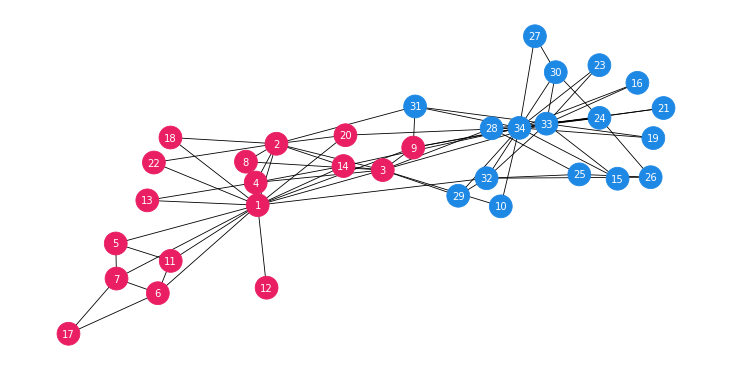

In [14]:
G = nx.from_numpy_array(A)

labels = {}
colores_fondo = []
for n in G.nodes():
    labels[n] = n + 1
    if (karate_labels[n] == 0):
        colores_fondo.append("#E91E63")
    else:
        colores_fondo.append("#1E88E5")

pos = nx.spring_layout(G, seed = 100)
fig = plt.figure(1, figsize=(12, 6), dpi=60)
nx.draw(G, pos=pos, labels=labels, node_color = colores_fondo, font_color="white", node_size=750)
plt.savefig("graficos/karateclub-distribucion-real.svg", format="SVG")

Se puede ver que hay una conexión de a varios nodos. Veamos los nodos más influyentes de esta red. Para ello primero calculamos la centralidad del autovector.

In [15]:
# Obtengo el vector de centralidad
central_autovector_obj = centralidad_autovector(eigenvalues_karate, eigenvectors_karate)

central_autovector = []
print(F"Maximo Autovalor: {eigenvalues_karate[0]} siendo el autovalor 0")

for k in central_autovector_obj.keys():
    central_autovector.append(central_autovector_obj[k])

# Vemos la centralidad en orden
print("Centralidad de los nodos")
nodos_relevancia = []
o = dict(sorted(central_autovector_obj.items(), key=lambda item: -item[1]))
for k in o.keys():
    nodos_relevancia.append([F"{k}", o[k]])        
print("")

df_nodos_relevantes = pd.DataFrame(nodos_relevancia, columns=["Nodo", "Centralidad"]);
df_nodos_relevantes

Maximo Autovalor: 6.7257 siendo el autovalor 0
Centralidad de los nodos



,Nodo,Centralidad
0,34,0.373419
1,1,0.355454
2,3,0.317178
3,33,0.308689
4,2,0.265932
5,9,0.227405
6,14,0.226452
7,4,0.211150
8,32,0.191039
9,31,0.174766


Si hacemos una impresión del grafo en relación a la centralidad de los nodos usando el vector normalizado, tenemos algo como:

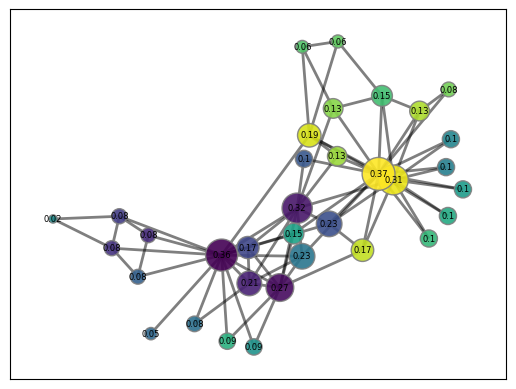

In [16]:
G_Centrality = nx.from_numpy_array(A) 
pos = nx.spring_layout(G_Centrality)
edges = G_Centrality.edges()

# central_autovector_normalizado
node_sizes = []
for v in central_autovector:
    node_sizes.append(1500*v)

nodes = G_Centrality.nodes()
    
colors = [i/len(G.nodes) for i in range(len(G.nodes))]

options = {"edgecolors": "tab:gray", "node_size": node_sizes, "alpha": 0.9}
nx.draw_networkx_nodes(G_Centrality, pos, nodelist=nodes, node_color=colors, **options)

nx.draw_networkx_edges(G,pos, edgelist=edges, width=2,alpha=0.5)
labels = {}
for i in range(0, len(central_autovector)):
    value = str(round(central_autovector[i], 2))
    labels[i] = value
    
nx.draw_networkx_labels(G, pos, labels, font_size=6, font_color="black")

plt.savefig("graficos/karateclub-centralidad.svg", format="SVG")

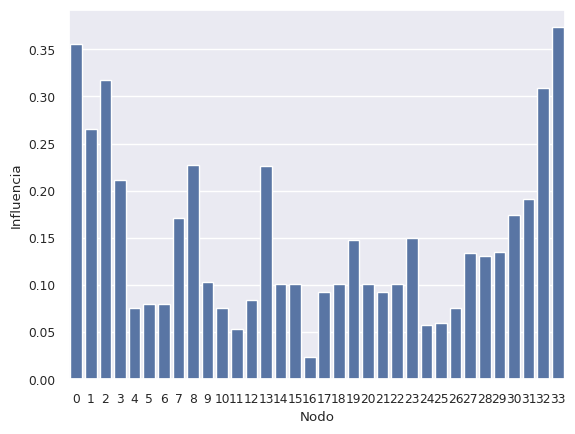

In [17]:
influencia_nodos = []
for i in range(0, len(central_autovector)):
    influencia_nodos.append([i, central_autovector[i]])

df_influencias = pd.DataFrame(influencia_nodos, columns=["Nodo", "Influencia"]);

name = F"Influencia de las páginas"

sns.set(font_scale = 0.8)
fig = sns.barplot(
    data=df_influencias, 
    x='Nodo', 
    y='Influencia'
);

fig.set(xlabel='Nodo', ylabel='Influencia');
plt.savefig("graficos/karate-referenciadas-influencia-barras.svg", bbox_inches = 'tight');

Este grafo nos da una idea sobre como se podrían ir separando los grupos dada la influencia.
Aquellos colores más cercanos a los amarillos son un grupo mientras los más cercanos al violeta son otros.
Los más cercanos al azul no podriamos dar una conclusión fija, todo dependería de que color contenga más en su composición ya sea, amarillo o violeta.

## Ahora trabajamos con la Laplaciana

Ahora trabajamos con la laplaciana
- Construimos la matriz laplaciana
- Corremos el metodo de la potencia y conseguimos autovalores y autovectores

In [18]:
L = laplaciana(A)

# La guardamos como .txt
imprimir_matriz(path_karate, "laplaciana.txt", L)

# Ejecutamos el metodo de la potencia con deflación
correr_metodo_potencia(F"{path_karate}/laplaciana.txt", 10000, 1e-6)

# Obtenemos autovalores y autovectores
eigenvalues_laplaciana = obtener_matriz(F"{path_karate}/laplaciana.txt-autovalores.out", "f")
eigenvectors_laplaciana = obtener_matriz(F"{path_karate}/laplaciana.txt-autovectores.out", "c")

# Usamos Numpy para traer los autovalores y autovectores
eigenvalues_laplaciana_np, eigenvectors_laplaciana_np = metodo_potencia_numpy(L)

Por ultimo nos queda estudiar la laplaciana con la de adyacencias
Para ello:
- Tenemos que conseguir la predicción con los autovectores de la laplaciana
- Para tal motivo uso la matriz de los labels de karate y voy a calcular su correlación respecto de los autovectores de la matriz laplaciana

### Nuestra Implementación

In [19]:
correlaciones = []
for v in eigenvectors_laplaciana:
    cor = correlacion(karate_labels, v)
    correlaciones.append(abs_val(cor))

In [20]:
max_corr = maximo(correlaciones)
mejor_autovalor = eigenvalues_laplaciana[max_corr[1]]
mejor_autovector = eigenvectors_laplaciana[max_corr[1]]

print(mejor_autovalor)
print(mejor_autovector)

0.468525
[-0.112138  -0.041288   0.0232189 -0.0554999 -0.284604  -0.323727
 -0.323727  -0.0525861  0.0516013  0.0928009 -0.284604  -0.210994
 -0.109462  -0.0147421  0.162751   0.162751  -0.422765  -0.100182
  0.162751  -0.0136372  0.162751  -0.100182   0.162751   0.155695
  0.153026   0.160963   0.18711    0.127664   0.0951523  0.16765
  0.0734996  0.0987535  0.130346   0.118903 ]


Analicemos las correlaciones y comparemos con el vector de centralidad

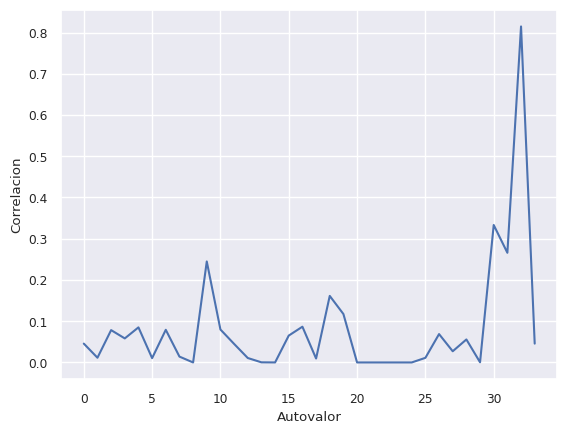

In [21]:
correlacion_centralidad = []
numero_autovalor = []
for i in range(0, len(correlaciones)):
    # print(F"Autovalor {i}: {eigenvalues_laplaciana[i]} con correlacion {correlaciones[i]}")
    correlacion_centralidad.append([eigenvalues_laplaciana[i], correlaciones[i], i])
    numero_autovalor.append(i)

df_centralidad_correlacion = pd.DataFrame(correlacion_centralidad, columns=["Autovalor", "Correlacion", "Indice"]);

fig = sns.lineplot(
    data=df_centralidad_correlacion, 
    x='Indice', 
    y='Correlacion',

);

fig.set(xlabel='Autovalor', ylabel='Correlacion');
plt.savefig("graficos/karateclub-referenciadas-correlacion-influencia.svg", bbox_inches = 'tight');

In [22]:
# Obtengo el de mayor correlacion
index_cor = sorted(range(len(correlaciones)), key=lambda i: correlaciones[i], reverse=True)[:5]
print(F"Posición {index_cor[0]} con correlación: {correlaciones[index_cor[0]]}")
print(F"Autovalor: {eigenvalues_laplaciana[index_cor[0]]}")
print(F"Autovector: {eigenvectors_laplaciana[index_cor[0]]}")

Posición 32 con correlación: 0.8147271732238485
Autovalor: 0.468525
Autovector: [-0.112138  -0.041288   0.0232189 -0.0554999 -0.284604  -0.323727
 -0.323727  -0.0525861  0.0516013  0.0928009 -0.284604  -0.210994
 -0.109462  -0.0147421  0.162751   0.162751  -0.422765  -0.100182
  0.162751  -0.0136372  0.162751  -0.100182   0.162751   0.155695
  0.153026   0.160963   0.18711    0.127664   0.0951523  0.16765
  0.0734996  0.0987535  0.130346   0.118903 ]


Sabemos que la red se ve como:

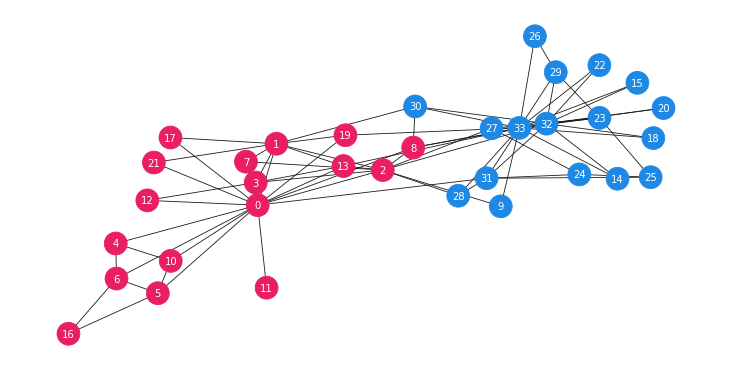

In [23]:
G = nx.from_numpy_array(A)

labels = {}
colores_fondo = []
for n in G.nodes():
    labels[n] = n
    if (karate_labels[n] == 0):
        colores_fondo.append("#E91E63")
    else:
        colores_fondo.append("#1E88E5")

pos = nx.spring_layout(G, seed = 100)
fig = plt.figure(1, figsize=(12, 6), dpi=60)
nx.draw(G, pos=pos, labels=labels, node_color = colores_fondo, font_color="white", node_size=750)

Veamos que división podemos armar respecto a la correlación

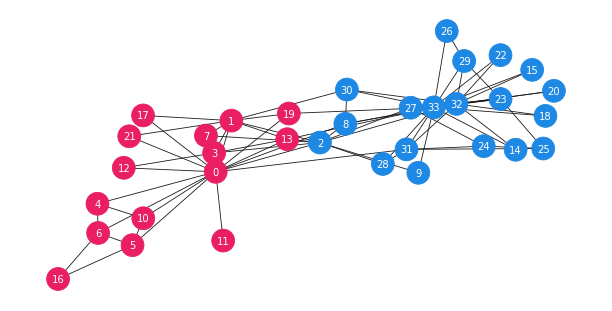

In [24]:
# Armo el vector x en función de los valores del autovector
x = []
for valor in mejor_autovector:
    if (valor > 0):
        x.append(1)
    else:
        x.append(0)

# Genero el grafo
G = nx.from_numpy_array(A)

# Genero los numeros de nodo
labels = {}
colores_fondo = []
for n in G.nodes():
    labels[n] = n
        
# Genero los colores segun la divión calculada
colores_fondo = []
for n in G.nodes():
    if (x[n] == 0):
        colores_fondo.append("#E91E63")
    else:
        colores_fondo.append("#1E88E5")
        
# Dibujo el grafo calculado
fig2 = plt.figure(2, figsize=(10, 5), dpi=60)
nx.draw(G, pos=pos, labels=labels, node_color = colores_fondo, font_color="white", node_size=750)          
plt.savefig("graficos/karateclub-separacion-correlacion.svg", format="SVG")

### Implementación con Numpy

In [25]:
correlaciones_np = []
for v in eigenvectors_laplaciana_np.T:
    cor = correlacion(karate_labels, v)
    correlaciones_np.append(abs_val(cor))

In [26]:
max_corr_np = maximo(correlaciones_np)
mejor_autovalor_np = eigenvalues_laplaciana_np[max_corr_np[1]]
mejor_autovector_np = eigenvectors_laplaciana_np.T[max_corr_np[1]]

print(mejor_autovalor_np)
print(mejor_autovector_np)

0.4685252267013859
[ 0.11213743  0.04128789 -0.02321896  0.05549978  0.28460453  0.32372722
  0.32372722  0.052586   -0.05160128 -0.09280089  0.28460453  0.21099295
  0.1094613   0.01474197 -0.16275078 -0.16275078  0.42276533  0.10018142
 -0.16275078  0.01363713 -0.16275078  0.10018142 -0.16275078 -0.15569457
 -0.15302558 -0.16096292 -0.18710956 -0.12766405 -0.0951523  -0.16765031
 -0.07349964 -0.09875343 -0.13034546 -0.11890326]


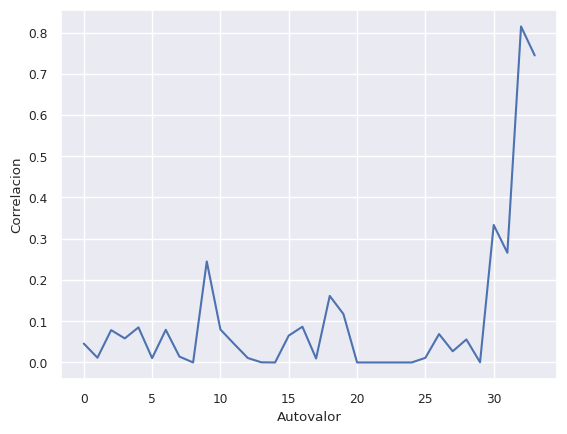

In [27]:
correlacion_centralidad_np = []
numero_autovalor_np = []
for i in range(0, len(correlaciones_np)):
    # print(F"Autovalor {i}: {eigenvalues_laplaciana[i]} con correlacion {correlaciones[i]}")
    correlacion_centralidad_np.append([eigenvalues_laplaciana_np.T[i], correlaciones_np[i], i])
    numero_autovalor_np.append(i)

df_centralidad_correlacion_np = pd.DataFrame(correlacion_centralidad_np, columns=["Autovalor", "Correlacion", "Indice"]);

fig = sns.lineplot(
    data=df_centralidad_correlacion_np, 
    x='Indice', 
    y='Correlacion',

);

fig.set(xlabel='Autovalor', ylabel='Correlacion');
plt.savefig("graficos/karateclub-referenciadas-correlacion-influencia-np.svg", bbox_inches = 'tight');

In [28]:
# Obtengo el de mayor correlacion
index_cor_np = sorted(range(len(correlaciones_np)), key=lambda i: correlaciones_np[i], reverse=True)[:5]
print(F"Posición {index_cor_np[0]} con correlación: {correlaciones_np[index_cor_np[0]]}")
print(F"Autovalor: {eigenvalues_laplaciana_np.T[index_cor_np[0]]}")
print(F"Autovector: {eigenvectors_laplaciana_np.T[index_cor_np[0]]}")

Posición 32 con correlación: 0.8147266286635977
Autovalor: 0.4685252267013859
Autovector: [ 0.11213743  0.04128789 -0.02321896  0.05549978  0.28460453  0.32372722
  0.32372722  0.052586   -0.05160128 -0.09280089  0.28460453  0.21099295
  0.1094613   0.01474197 -0.16275078 -0.16275078  0.42276533  0.10018142
 -0.16275078  0.01363713 -0.16275078  0.10018142 -0.16275078 -0.15569457
 -0.15302558 -0.16096292 -0.18710956 -0.12766405 -0.0951523  -0.16765031
 -0.07349964 -0.09875343 -0.13034546 -0.11890326]


Usamos el mismo criterio que antes para partir la red

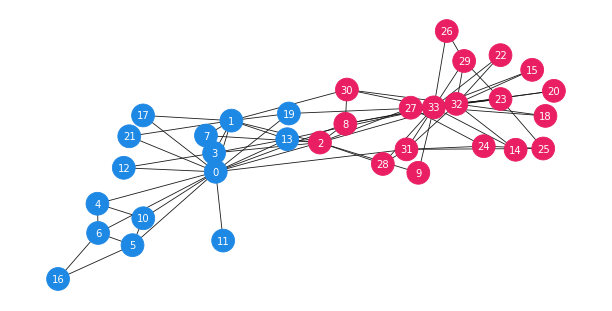

In [29]:
# Armo el vector x en función de los valores del autovector
x_np = []
for valor_np in mejor_autovector_np:
    if (valor_np > 0):
        x_np.append(1)
    else:
        x_np.append(0)

# Genero el grafo
G_np = nx.from_numpy_array(A)

# Genero los numeros de nodo
labels_np = {}
colores_fondo_np = []
for n in G_np.nodes():
    labels_np[n] = n
        
# Genero los colores segun la divión calculada
colores_fondo_np = []
for n in G_np.nodes():
    if (x_np[n] == 0):
        colores_fondo_np.append("#E91E63")
    else:
        colores_fondo_np.append("#1E88E5")
        
# Dibujo el grafo calculado
fig2 = plt.figure(2, figsize=(10, 5), dpi=60)
nx.draw(G_np, pos=pos, labels=labels_np, node_color = colores_fondo_np, font_color="white", node_size=750)          
plt.savefig("graficos/karateclub-separacion-correlacion-np.svg", format="SVG")

Grafico comparativo Numpy vs Implementación del Algoritmo

In [30]:
corr_df = []
for line in correlacion_centralidad:
    corr_df.append([line[0],line[1],line[2],'IT'])

for line in correlacion_centralidad_np:
    corr_df.append([line[0],line[1],line[2],'NP'])

In [31]:
df_centralidad_correlacion_comp = pd.DataFrame(corr_df, columns=["Autovalor", "Correlacion", "Indice", "Method"]);

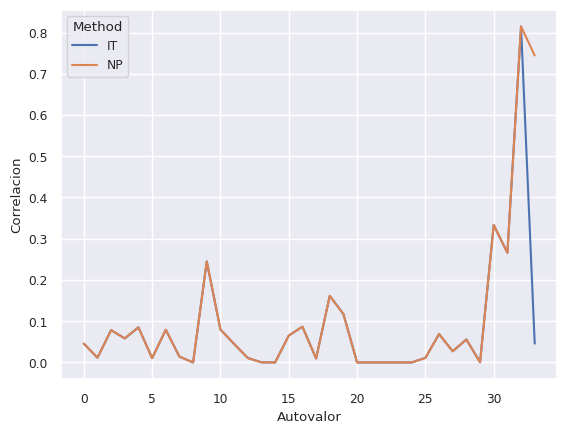

In [32]:
fig = sns.lineplot(
    data=df_centralidad_correlacion_comp, 
    x='Indice', 
    y='Correlacion',
    hue='Method'
);

fig.set(xlabel='Autovalor', ylabel='Correlacion');
plt.savefig("graficos/karateclub-referenciadas-correlacion-influencia_comp.svg", bbox_inches = 'tight');

### Numero Algebraico

Como podemos observar, tenemos que el anteultimo autovector de la matriz laplaciana es el que mejor predice. Veamos que nos dice el numero algebraico

In [33]:
numero_algebraico = conectividad_algebraica(eigenvalues_laplaciana, eigenvectors_laplaciana)

In [34]:
print(F"Número Algebraico: {numero_algebraico[0]} es el autovector: {numero_algebraico[2]}\nSu vector asociado:\n{numero_algebraico[1]}")

Número Algebraico: 0.468525 es el autovector: 32
Su vector asociado:
[-0.112138  -0.041288   0.0232189 -0.0554999 -0.284604  -0.323727
 -0.323727  -0.0525861  0.0516013  0.0928009 -0.284604  -0.210994
 -0.109462  -0.0147421  0.162751   0.162751  -0.422765  -0.100182
  0.162751  -0.0136372  0.162751  -0.100182   0.162751   0.155695
  0.153026   0.160963   0.18711    0.127664   0.0951523  0.16765
  0.0734996  0.0987535  0.130346   0.118903 ]


El numero algebráico no es 0 pero si es cercano a 0, por lo cual, hay una división de grupos que no es exactamente una partición a la mitad, si no que, un grupo tendrá una cantidad mayor de elementos. Veamos como podemos armar estos grupos:

In [35]:
# Podemos uasr este vector para decir que nodos pertenecen a un grupo y que a otros
# Para ello uso dos vectores distintos
grupo_zero = []
grupo_uno = []
# Con esto, recorro el autovector y me quedo con los valores negativos para el grupo 0 y los positivos para el grupo 1
fiedler_vector = numero_algebraico[1]
for i in range(0, len(fiedler_vector)):
    if fiedler_vector[i] < 0:
        grupo_zero.append(i)
    else:
        grupo_uno.append(i)
        
print(F"Grupo Zero: {grupo_zero}")
print(F"Grupo Uno: {grupo_uno}")

Grupo Zero: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Grupo Uno: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


#### Aca tenemos el vector de Fiedler pero desde NetworkX

In [36]:
G = nx.from_numpy_array(A)
fiedler_vector_nx = nx.fiedler_vector(G)
algebraic_connection_nx = nx.algebraic_connectivity(G)
print(algebraic_connection_nx)
print(fiedler_vector_nx)

0.4685252267014063
[-0.11213744 -0.0412879   0.02321895 -0.05549979 -0.2846045  -0.32372719
 -0.32372719 -0.05258601  0.05160128  0.09280089 -0.2846045  -0.21099312
 -0.10946131 -0.01474198  0.16275079  0.16275079 -0.42276527 -0.10018143
  0.16275079 -0.01363714  0.16275079 -0.10018143  0.16275079  0.15569457
  0.15302558  0.16096293  0.18710957  0.12766405  0.0951523   0.16765032
  0.07349964  0.09875343  0.13034546  0.11890327]


¡El mismo coincide con la predicción! El autovector dado por la mayor correlación y el numero algebraico coincide! Inclusive, usando el vector de fiedler dado por NetworkX. Usaremos esto como medida.

Vemos que tenemos casi lo mismo, ahora podemos graficar perfectamente dos grupos.

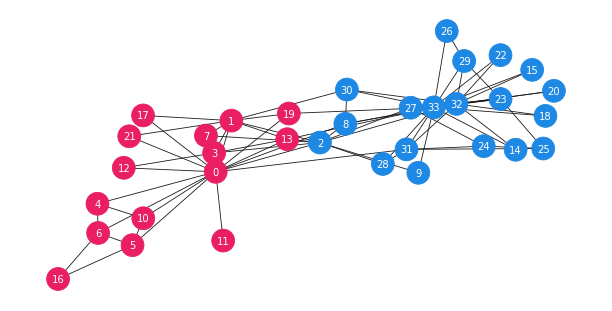

In [37]:
# Armo el vector x en función de los valores del autovector
nodes_G_E = []
G_E = nx.from_numpy_array(A)

for i in range(0, len(fiedler_vector)):
    if (fiedler_vector[i] > 0):
        nodes_G_E.append(1)
    else:
        nodes_G_E.append(0)

# Genero los numeros de nodo
labels = {}
colores_fondo = []
for n in G_E.nodes():
    labels[n] = n
        
# Genero los colores segun la divión calculada
colores_fondo = []
for n in G_E.nodes():
    if (nodes_G_E[n] == 0):
        colores_fondo.append("#E91E63")
    else:
        colores_fondo.append("#1E88E5")
        
# Dibujo el grafo calculado
fig2 = plt.figure(2, figsize=(10, 5), dpi=60)
nx.draw(G, pos=pos, labels=labels, node_color = colores_fondo, font_color="white", node_size=750)        

plt.savefig("graficos/karateclub-separaciongrupos-algebraico.svg", format="SVG")

Comparemos con el valor real de los grupos a ver que ocurre

In [38]:
karate_labels
grupo_zero_labels = []
grupo_uno_labels = []
for i in range(0, len(karate_labels)):
        if int(karate_labels[i]) == 0:
            grupo_zero_labels.append(i)
        else:
            grupo_uno_labels.append(i)

In [39]:
print(F"Pertenecientes al grupo Zero real: {grupo_zero_labels}")
print(F"Pertenecientes al grupo Zero prediccion: {grupo_zero}")
zero_intersection = list(set(grupo_zero_labels) & set(grupo_zero))
zero_difference = list(set(grupo_zero_labels) - set(grupo_zero))
print(F"Interseccion entre grupo real y prediccion: {zero_intersection}")
print(F"Diferencia entre grupo real y prediccion: {zero_difference}")

Pertenecientes al grupo Zero real: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
Pertenecientes al grupo Zero prediccion: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Interseccion entre grupo real y prediccion: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Diferencia entre grupo real y prediccion: [8, 2]


In [40]:
print(F"Pertenecientes al grupo Uno real: {grupo_uno_labels}")
print(F"Pertenecientes al grupo Uno prediccion: {grupo_uno}")
uno_intersection = sorted(list(set(grupo_uno_labels) & set(grupo_uno)))
uno_difference = sorted(list(set(grupo_uno) - set(grupo_uno_labels)))
print(F"Interseccion entre grupo real y prediccion: {uno_intersection}")
print(F"Diferencia entre grupo real y prediccion: {uno_difference}")

Pertenecientes al grupo Uno real: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Pertenecientes al grupo Uno prediccion: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Interseccion entre grupo real y prediccion: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Diferencia entre grupo real y prediccion: [2, 8]


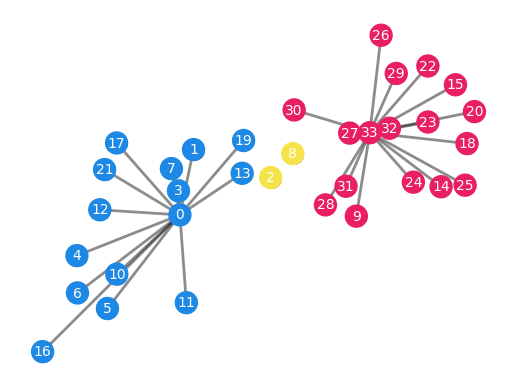

In [41]:
E_A = np.zeros(A.shape)

G_E_A = nx.from_numpy_array(E_A)

nodes_G_E_A = []

for i in range(0, len(fiedler_vector)):
    if i == 2:
        nodes_G_E_A.append(2)
    elif i == 8:
        nodes_G_E_A.append(2)
    elif i in zero_intersection:
        nodes_G_E_A.append(1)
    else:
        nodes_G_E_A.append(0)

grupo_zero_interseccion_edges = []
for item in zero_intersection:
    if item != 0:
        E_A[0][item] = 1
        E_A[item][0] = 1
        grupo_zero_interseccion_edges.append((0, item))
    
grupo_uno_interseccion_edges = []
for item in uno_intersection:
    if item != 33:
        E_A[33][item] = 1
        E_A[item][33] = 1
        grupo_uno_interseccion_edges.append((33, item))


#nx.draw_spring(G_E, with_labels=True, node_color='#30c4e6')
edges = G_E_A.edges()

colores_fondo = []
for n in G_E_A.nodes():
    if nodes_G_E_A[n] == 0:
        colores_fondo.append("#E91E63")
    elif nodes_G_E_A[n] == 1:
        colores_fondo.append("#1E88E5")
    else:
        colores_fondo.append("#F5E449")

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(G_E_A,pos, nodelist=zero_intersection, node_color='#E91E63', **options)
nx.draw_networkx_nodes(G_E_A,pos, nodelist=uno_intersection, node_color='#1E88E5', **options)

nx.draw_networkx_nodes(G_E_A,pos, nodelist=zero_difference, node_color='#f5e449', **options)
nx.draw_networkx_nodes(G_E_A,pos, nodelist=uno_difference, node_color='#f5e449', **options)

nx.draw_networkx_edges(G_E_A,pos, edgelist=grupo_zero_interseccion_edges, width=2,alpha=0.5)
nx.draw_networkx_edges(G_E_A,pos, edgelist=grupo_uno_interseccion_edges, width=2,alpha=0.5)

labels = {}
for i in range(0, len(central_autovector)):
    labels[i] = i
    
# Dibujo el grafo calculadoG_E_A, pos=pos, labels=labels, node_color = colores_fondo, font_color="black", node_size=250, font_size=10)        
nx.draw(G_E_A, pos=pos, labels=labels, node_color = colores_fondo, font_color="white", node_size=250, font_size=10)     

plt.savefig("graficos/karateclub-separaciongrupos-interseccion.svg", format="SVG")